In [1]:
import datetime as dt
import pandas as pd
import requests
import re
import time
import calendar as cal
from io import StringIO
# except ImportError:
#     from StringIO import StringIO

class Fetcher:
    api_url = "https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%s&period2=%s&interval=%s&events=%s&crumb=%s"
    def __init__(self, ticker, start, end=None, interval="1d"):
        """Initializes class variables and formats api_url string"""
        self.ticker = ticker.upper()
        self.interval = interval
        self.cookie, self.crumb = self.init()
        self.start = int(cal.timegm(dt.datetime(*start).timetuple()))

        if end is not None:
            self.end = int(cal.timegm(dt.datetime(*end).timetuple()))
        else:
            self.end = int(time.time())

    def init(self):
        """Returns a tuple pair of cookie and crumb used in the request"""
        url = 'https://finance.yahoo.com/quote/%s/history' % (self.ticker)
        r = requests.get(url)
        txt = r.content
        cookie = r.cookies['B']
        pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')

        for line in txt.splitlines():
            m = pattern.match(line.decode("utf-8"))
            if m is not None:
                crumb = m.groupdict()['crumb']
                crumb = crumb.replace(u'\\u002F', '/')
        return cookie, crumb  # return a tuple of crumb and cookie

    def getData(self, events):
        """Returns a list of historical data from Yahoo Finance"""
        if self.interval not in ["1d", "1wk", "1mo"]:
            raise ValueError("Incorrect interval: valid intervals are 1d, 1wk, 1mo")

        url = self.api_url % (self.ticker, self.start, self.end, self.interval, events, self.crumb)

        data = requests.get(url, cookies={'B':self.cookie})
        content = StringIO(data.content.decode("utf-8"))
        return pd.read_csv(content, sep=',')

    def getHistorical(self, events='history'):
        """Returns a list of historical price data from Yahoo Finance"""
        return self.getData('history')

    def getDividends(self):
        """Returns a list of historical dividends data from Yahoo Finance"""
        return self.getData('div')

    def getSplits(self):
        """Returns a list of historical splits data from Yahoo Finance"""
        return self.getData('split')

    def getDatePrice(self):
        """Returns a DataFrame for Date and Price from getHistorical()"""
        return self.getHistorical().ix[:,[0,4]]

    def getDateVolume(self):
        """Returns a DataFrame for Date and Volume from getHistorical()"""
        return self.getHistorical().ix[:,[0,6]]

In [2]:
import datetime as datetime
import numpy as np

today_date = datetime.datetime.today()
today_date += datetime.timedelta(days = 1)

today_date = str(today_date).split()[0]
year=int(today_date[0:4])
month=int(today_date[5:7])
day=int(today_date[8:10])

In [3]:
data = Fetcher('^VIX', [year-30,month,day], [year,month,day])
original_data=data.getHistorical()

print(len(original_data['Close']))
original_data.to_csv('^VIX.csv',index=False)

7557


In [4]:
original_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-05-08,17.780001,17.780001,17.780001,17.780001,17.780001,0
1,1991-05-09,17.170000,17.170000,17.170000,17.170000,17.170000,0
2,1991-05-10,17.540001,17.540001,17.540001,17.540001,17.540001,0
3,1991-05-13,17.660000,17.660000,17.660000,17.660000,17.660000,0
4,1991-05-14,18.000000,18.000000,18.000000,18.000000,18.000000,0


In [5]:
import pandas as pd
from random import randrange
import numpy as np
import matplotlib.pyplot as plt

In [6]:
vix_data = pd.read_csv("^VIX.csv")
vix_data = vix_data.rename(columns = {"Date":"Date",\
                           "Open":"vix_open",\
                           "High":'vix_high',\
                           'Low':'vix_low',\
                           'Close':'vix_close',\
                           'Adj Close':'vix_adj_close',\
                           'Volume':'vix_volume'})

# Construct a feature

In [7]:
#compute the exponential moving average


mv_10 = vix_data['vix_adj_close'].ewm(span = 10).mean()
mv_20 = vix_data['vix_adj_close'].ewm(span = 20).mean()
mv_30 = vix_data['vix_adj_close'].ewm(span = 30).mean()
mv_50 = vix_data['vix_adj_close'].ewm(span = 50).mean()
mv_100 = vix_data['vix_adj_close'].ewm(span = 100).mean()

In [8]:
spot_to_mv_10 = vix_data['vix_adj_close']/mv_10
spot_to_mv_20 = vix_data['vix_adj_close']/mv_20
spot_to_mv_30 = vix_data['vix_adj_close']/mv_30
spot_to_mv_50 = vix_data['vix_adj_close']/mv_50
spot_to_mv_100 = vix_data['vix_adj_close']/mv_100

In [9]:
vix_measure = spot_to_mv_10+spot_to_mv_20+spot_to_mv_30+spot_to_mv_50+spot_to_mv_100
vix_measure_list = vix_measure.tolist()

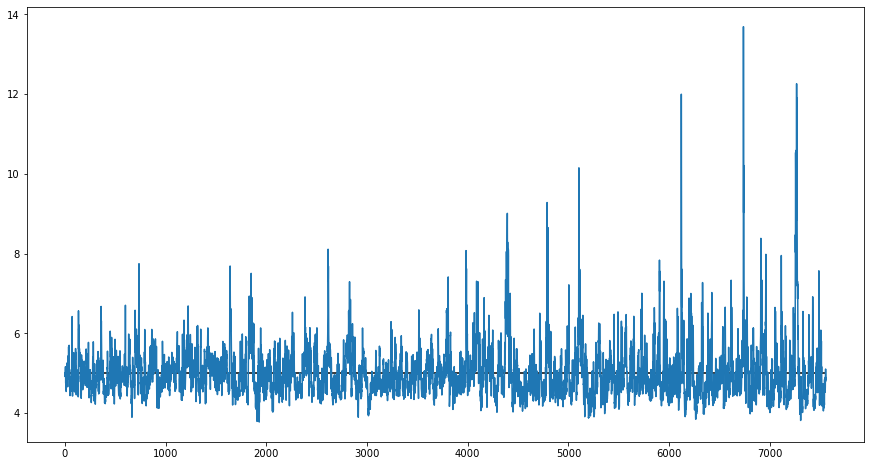

In [10]:
plt.rcParams["figure.figsize"] = (15,8)

plt.hlines(5,0,len(vix_measure_list),color = 'black')

plt.plot(vix_measure_list)
plt.show()

# Zoom in on the feature
we only look at the most recent 300 days of the feature. 
<br>
We arbitrarily pick 6 as a threshold, though any other number would work as well. 
<br>
The red line shows the current value of the feature. 

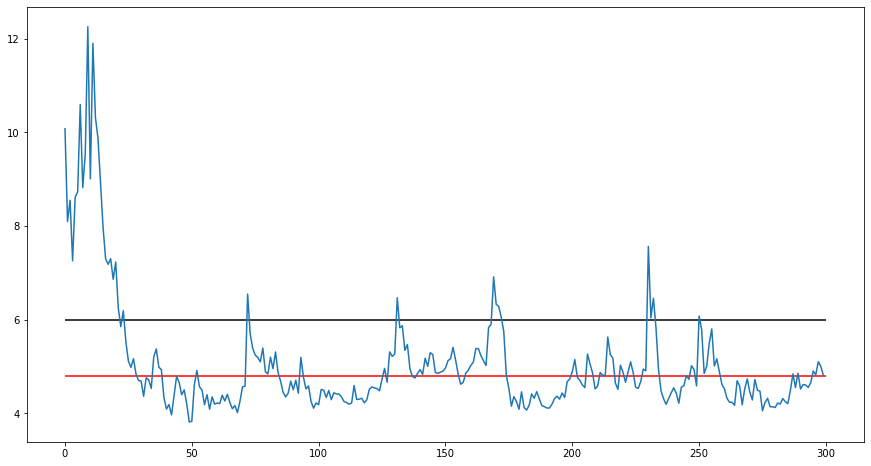

In [11]:
most_recent_days = 300

plt.rcParams["figure.figsize"] = (15,8)

plt.hlines(6,0,len(vix_measure_list[-300:]),color = 'black')
plt.hlines(vix_measure_list[-1],0,len(vix_measure_list[-300:]),color = 'red')

plt.plot(vix_measure_list[-1*most_recent_days:])
plt.show()

# visualize with a histogram
We plot all the available data into a histogram. 
<br>
We use a red line to denote the feature's numerical value for today's data. 

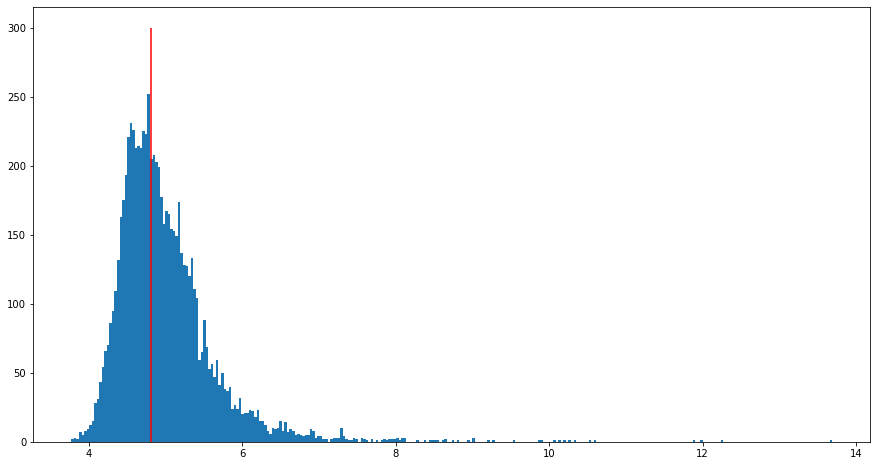

In [12]:
plt.hist(vix_measure_list,bins = 300)
plt.vlines(vix_measure_list[-1],0,300,color = 'red')
plt.show()


In [13]:
#we count what percentage of the data is to the left of the red line in the above graph

histogram_count,histogram_cut_off = np.histogram(vix_measure_list,bins=300)

count_to_the_left = 0

for index in range(0,len(histogram_count)):
     
    if histogram_cut_off[index]<vix_measure_list[-1]:
        count_to_the_left += histogram_count[index]
        
print(count_to_the_left/np.sum(histogram_count))

0.4672489082969432


# days between spikes
We arbitrarily pick 6 as a threshold and count how many days usually lap between two spikes above 6

In [14]:
#days between two vix spike

vix_threshold = 6

days_between_vix_spike = []

for _ in range(0,15000):

    begin_index = randrange(0,len(vix_measure_list)-1)
    end_index = randrange(begin_index+1,len(vix_measure_list))
    selected_data = vix_measure_list[begin_index:end_index]

    if selected_data[0]<vix_threshold*0.8:
        
        for index in range(0,len(selected_data)):
            if selected_data[index]>=vix_threshold:
                days_between_vix_spike.append(index)
                
                if index == 0:
                    print(selected_data)
                
                break
                
print(np.mean(days_between_vix_spike))

69.23532167395378


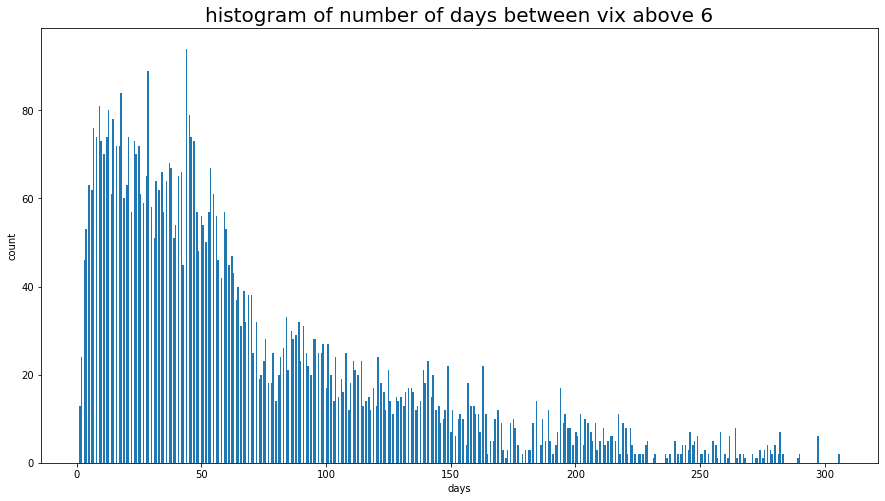

In [15]:
plt.hist(days_between_vix_spike,bins = 500)
plt.xlabel("days")
plt.ylabel("count")
plt.title("histogram of number of days between vix above 6",fontsize=20)
plt.show()

# Assume a Poisson Distribution

In [16]:
from scipy.stats import poisson

prob_of_at_least_happening_once_data = []

for day in range(1,300):
    mu_in_poisson = day*1/np.mean(days_between_vix_spike)
    prob_of_at_least_happening_once = 1-poisson.cdf(0,mu_in_poisson)
    prob_of_at_least_happening_once_data.append(prob_of_at_least_happening_once)

In [17]:
#where are we now
#count how many days has passed since the last vix spike. 
#in this case, we are definien a fix spike as when the feature goes above 6

vix_measure_list_reverse = vix_measure_list[::-1]

found_spike = False
days_since_last_vix_spike = 1

while not found_spike:
    if vix_measure_list_reverse[days_since_last_vix_spike]<vix_threshold:
        days_since_last_vix_spike += 1
    else:
        found_spike = True
        
print(days_since_last_vix_spike)

49


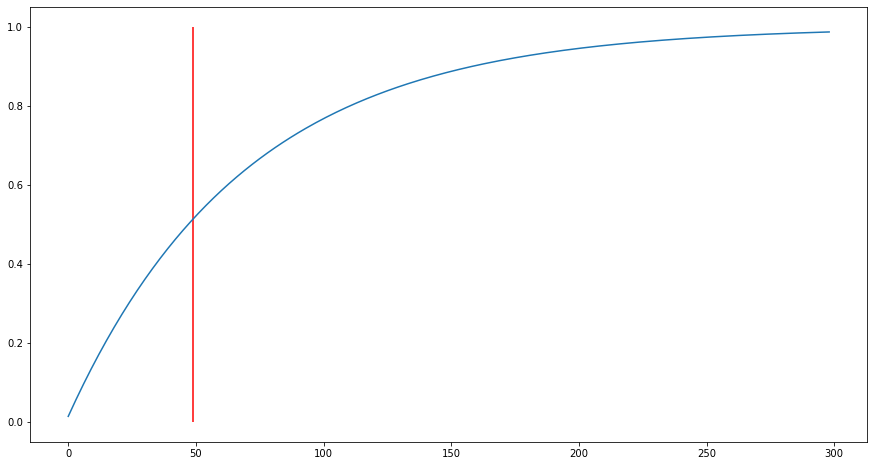

0.5143051504217422


In [18]:
plt.plot(prob_of_at_least_happening_once_data)
plt.vlines(days_since_last_vix_spike,0,1,color = 'red')
plt.show()
print(prob_of_at_least_happening_once_data[days_since_last_vix_spike])

# only look at recent data
Before, when we counted the number of days between two vix spikes, we used all historical days
<br>
Now, we will only use the most recent 1000 days for the counting purpose. 

In [19]:
#days between two vix spike based on data from the past 1000 days

recent_vix_measure_list = vix_measure_list[-1000:]

vix_threshold = 6

days_between_vix_spike = []

for _ in range(0,5000):

    begin_index = randrange(0,len(recent_vix_measure_list)-1)
    end_index = randrange(begin_index+1,len(recent_vix_measure_list))
    selected_data = recent_vix_measure_list[begin_index:end_index]

    if selected_data[0]<vix_threshold*0.8:
        
        for index in range(0,len(selected_data)):
            if selected_data[index]>=vix_threshold:
                days_between_vix_spike.append(index)
                
                if index == 0:
                    print(selected_data)
                
                break

In [20]:
np.mean(days_between_vix_spike)

30.799908424908423

In [21]:
from scipy.stats import poisson

prob_of_at_least_happening_once_data = []

for day in range(0,300):
    mu_in_poisson = day*1/np.mean(days_between_vix_spike)
    prob_of_at_least_happening_once = 1-poisson.cdf(0,mu_in_poisson)
    prob_of_at_least_happening_once_data.append(prob_of_at_least_happening_once)

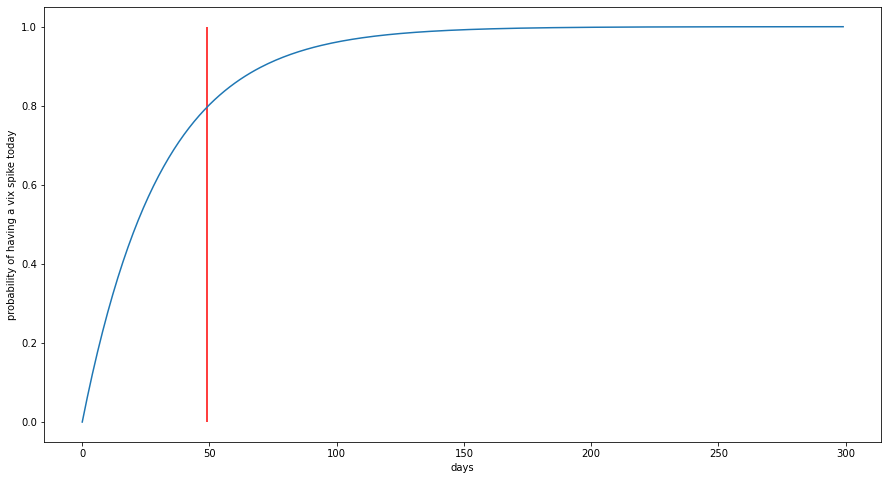

0.7962606546606569


In [22]:
plt.plot(prob_of_at_least_happening_once_data)
plt.vlines(days_since_last_vix_spike,0,1,color = 'red')
plt.xlabel("days")
plt.ylabel("probability of having a vix spike today")
plt.show()
print(prob_of_at_least_happening_once_data[days_since_last_vix_spike])